In [1]:
from jax.config import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as np
import numpy as onp
import matplotlib as mpl
import matplotlib.pyplot as plt
import importlib
import scft
import functools
import operator
import timeit
import utils
import relaxation as relax
from jax import jit, random
importlib.reload(scft)
importlib.reload(utils)
sech = lambda *args,**kwargs : 1 / np.cosh(*args, **kwargs)

x  : [0.000, 10.000), dx=1.562e-01 (64 points)
k  : [0.000, 20.735), dk=6.283e-01 (33 points)
f  : 1.000 
Ns : 200 A + 0 B = 200 segments 
Q=5.394e-01


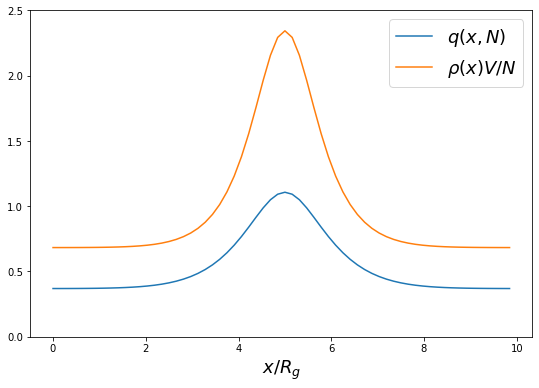

In [2]:
def testsingle(*,L,Num,chi,Na,Nb):
    def W(x):
        """Scaled potential function N w(x), lengths in units of Rg"""
        return 1 - 2*sech(3*(x - L/2)/2)**2
    
    ds       = 1/(Na + Nb)
    fft, ifft, x, k, k2     = utils.grid(L=L, N=Num)
    init, evolve            = scft.mdeSplit(fft, ifft, k2, ds)
    (diff,diff_c), solution = scft.diblock(init = init, evolve=evolve, chi=chi, Na=Na, Nb=Nb)

    diff,diff_c = jit(diff), jit(diff_c)
    solution    = jit(solution)
    
    Wx = W(x)
    Q, (q, _), (phi_a, phi_b), _ = solution(Wx, np.zeros_like(Wx))

    print(f"Q={Q:.3e}")
    fig,ax = plt.subplots(figsize=(9,6))
    ax.plot(x, q[-1,...], label=r'$q(x,N)$')
    ax.plot(x, phi_a, label=r'$\rho(x) V/N$')
    ax.set_xlabel(r'$x/R_g$',fontsize=18)
    ax.legend(fontsize=18)
    ax.set_ylim(0,2.5)
    plt.show()

testsingle(L=10, Num=64, Na=200, Nb=0, chi=1.0)

In [3]:
importlib.reload(scft)
def plotbinary(x,mus,phis,errs):
    fig,axes = plt.subplots(figsize=(18,4), ncols=3)
    ax,bx,cx = axes
    ax.plot(x, phis[1][0], label=r'$\phi_A$')
    ax.plot(x, phis[1][1],ls='--', label=r'$\phi_B$')
    bx.plot(x, mus[1][0], ls='--', label=r'$\mu_+$', color='C2')
    bx.plot(x, mus[1][1], label=r'$\mu_-$', color='C3')
    for xx in [ax,bx]:
        xx.legend(fontsize=14)
        xx.set_xlabel(r'$L/R_g$')
    for err,lbl in zip(errs,['Explicit', 'SIS']):
        cx.plot(err, label=lbl)
    cx.legend(fontsize=14)
    cx.set_ylim(1e-16,1e0)
    cx.set_ylabel(r'Error')
    cx.set_xlabel(r'Iterations')
    cx.semilogy()
    plt.show()
    
    return fig,axes

x  : [0.000, 10.000), dx=3.906e-02 (256 points)
k  : [0.000, 81.053), dk=6.283e-01 (129 points)
Euler time =  3.210 s
  SIS time =  0.631 s


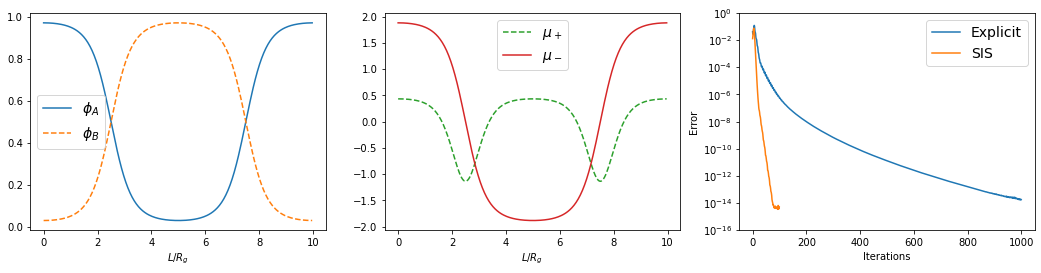

In [6]:
importlib.reload(scft)
importlib.reload(utils)
def snapshot(a, b):
    return 0.5*(utils.l1norm(a) + utils.l1norm(b))

def testmelt(*, init_guess, L, Num, chi, f, N):
    dt_euler, dt_sis    = 1.5, 50.0
    ds                  = 1/N
    fft, ifft, x, k, k2 = utils.grid(L=L, N=Num)
    init, evolve        = scft.mdeSplit(fft, ifft, k2, ds)
    diff, solution      = scft.binarymelt(init=init, evolve=evolve, chi=chi, f=f, N=N)

    saddle_euler = jit(utils.fold(relax.binary_euler(solver=solution, dt=dt_euler, trj=snapshot))(1000))
    saddle_sis   = jit(utils.fold(relax.binary_sis(solver=solution, dt=dt_sis, trj=snapshot, Gs=(scft.single_Debye(k2), 2/chi),
                                                  fft=fft, ifft=ifft))(100))
    
    mu0                = init_guess(x, L)
    mu_euler,err_euler = saddle_euler(*mu0)
    mu_sis, err_sis    = saddle_sis(*mu0)
    
    loops  = 1
    print(f"Euler time = {timeit.timeit('saddle_euler(*mu0)', globals=locals(), number=loops)/loops : .3f} s")
    print(f"  SIS time = {timeit.timeit('saddle_sis(*mu0)', globals=locals(), number=loops)/loops : .3f} s")

    _, _, phi_euler, _ = solution(*utils.binary_pm2ab(*mu_euler))
    _, _, phi_sis, _   = solution(*utils.binary_pm2ab(*mu_sis))
    return x,[mu_euler,mu_sis],[phi_euler,phi_sis],[err_euler, err_sis]

def initmelt(x,L):
    mup = -0.1*np.cos(2*np.pi/L * x)
    mum = 0.1*np.cos(2*np.pi/L* x )
    return mup, mum

fig, axes = plotbinary(*testmelt(init_guess = initmelt,  L=10.0, Num=256, chi=4.0, f=0.5, N=255))
fig.savefig('./binaryhomopolymer.png', dpi=300, bbox_inches='tight', facecolor='white')

x  : [0.000, 10.000), dx=3.906e-02 (256 points)
k  : [0.000, 81.053), dk=6.283e-01 (129 points)
f  : 0.500 
Ns : 128 A + 128 B = 256 segments 
Euler time =  3.328 s
  SIS time =  1.644 s


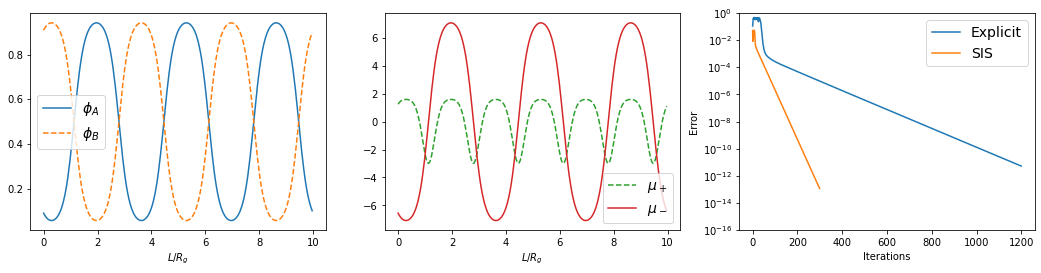

In [12]:
importlib.reload(scft)
importlib.reload(utils)
def testdiblock(*, init_guess, L, Num, chi, Na, Nb):
    dt_euler, dt_sis = 4.0, 500.0
    ds,f             = 1/(Na + Nb), Na/(Na+Nb)
    fft, ifft, x, k, k2 = utils.grid(L=L, N=Num)

    init, evolve     = scft.mdeSplit(fft, ifft, k2, ds)
    diff, solution   = scft.diblock(init=init, evolve=evolve, chi=chi, Na=Na, Nb=Nb)

    saddle_euler = jit(utils.fold(relax.binary_euler(solver=solution, dt=dt_euler, trj=snapshot))(1200))
    saddle_sis   = jit(utils.fold(relax.binary_sis(solver=solution, dt=dt_sis, trj=snapshot,
                                                  Gs=(scft.diblock_Debye(f, k2), 2/chi), fft=fft, ifft=ifft))(300))
    
    
    mu0                = init_guess(x, L)
    mu_euler,err_euler = saddle_euler(*mu0)
    mu_sis, err_sis    = saddle_sis(*mu0)
    
    loops  = 2
    print(f"Euler time = {timeit.timeit('saddle_euler(*mu0)', globals=locals(), number=loops)/loops : .3f} s")
    print(f"  SIS time = {timeit.timeit('saddle_sis(*mu0)', globals=locals(), number=loops)/loops : .3f} s")

    _, _, phi_euler, _ = solution(*utils.binary_pm2ab(*mu_euler))
    _, _, phi_sis, _ = solution(*utils.binary_pm2ab(*mu_sis))
    return x,[mu_euler,mu_sis],[phi_euler,phi_sis],[err_euler, err_sis]

def initdiblock(x,L):
    key = random.PRNGKey(1235711)
    mup,mum = random.normal(key, (2,)+x.shape)
    return mup, mum

fig, ax = plotbinary(*testdiblock(init_guess=initdiblock, chi=16.0, Na=128, Nb=128, L=10.0, Num=256))
fig.savefig('./diblockcopolymer.png', dpi=300, bbox_inches='tight', facecolor='white')